In [1]:
%%capture

# matplotlib inline plotting
%matplotlib inline

# activate jupyters tab completion
%config IPCompleter.greedy=True

%run utils/helper_final_presentation.py

# Final Presentation for NOHATE Related snorkel Project

- Christoph Geis-Schroer
- Sebastian Jäger


## Context Information

- ~12k comments in German, different sources
- 500 gold labels (at all, not per label)
- different classes/types of hatespeech (e.g. Intelligenz, Beschimpfung, Entmenschlichung)


### Goal of the Project

- label 12k data set
- infrastructure for future datasets


## State at the Last Presentation

- fullstack snorkel workflow
    - dictionary and regex based candidate extraction (3 types of hate speech)
    - few labeling functions
    - trained fastText model
- docker container


## Structural Improvements

- extendability
- GitLab CI
- Gold Label driven development

### Easily Extendable Files - Candidates Example

In [2]:
# Candidates
Intelligenz_BB3c      = candidate_subclass('Intelligenz', ['signal_word'])
WirkungaufBRD_BB3i    = candidate_subclass('WirkungaufBRD', ['signal_word'])
Implikation_BB4       = candidate_subclass('Implikation', ['signal_word'])
Beschimpfung_BB6a     = candidate_subclass('Beschimpfung', ['signal_word'])
Entmenschlichung_BB6e = candidate_subclass('Entmenschlichung', ['signal_word'])


# Regexes
intelligenz_regex      = make_regex(intelligenz_signal_words)
wirkungaufbrd_regex    = make_regex(wirkungaufbrd_signal_words)
implikation_regex      = make_regex(implikation_signal_words)
beschimpfung_regex     = make_regex(beschimpfung_signal_words, offense_signal_words, refugee_related_signal_words, negative_signal_words)
entmenschlichung_regex = make_regex(entmenschlichung_signal_words, animal_signal_words)

# pay attention: keep candidates in correct order.

candidate_classes = [
    Intelligenz_BB3c,
    WirkungaufBRD_BB3i,
    Implikation_BB4,
    Beschimpfung_BB6a,
    Entmenschlichung_BB6e
]

regex_classes = [
    intelligenz_regex,
    wirkungaufbrd_regex,
    implikation_regex,
    beschimpfung_regex,
    entmenschlichung_regex
]

# create (candidate, regex) tuples, combines the above lists
candidate_regex_tupels = [(candidate_class, candidate_regex) for candidate_class, candidate_regex in zip(candidate_classes, regex_classes)]

### Gold Label Driven Development

In [3]:
print(f"Candidate {class_name_presentation}:\n")
print(cross_tab_presentation)
    
print(f"\nAccuracy:\t{float(format(candidate_accuracy_presentation, '.3f'))}\n")
print(f"Precision per class [hate, no hate]:\t{[float(format(x, '.3f')) for x in candidate_precision_presentation]}")
print(f"Recall per class [hate, no hate]:\t{[float(format(x, '.3f')) for x in candidate_recall_presentation]}")
print(f"F1 score per class [hate, no hate]:\t{[float(format(x, '.3f')) for x in candidate_f_score_presentation]}")

Candidate Intelligenz:

SnorkelLabel    0   1
GoldLabel            
0             411  24
1              33  32

Accuracy:	0.886

Precision per class [hate, no hate]:	[0.571, 0.926]
Recall per class [hate, no hate]:	[0.492, 0.945]
F1 score per class [hate, no hate]:	[0.529, 0.935]


In [4]:
# print the error classes
for candidate_class in error_classes.keys():
    
    print(f"Hate speech dimension: {candidate_class.__name__}\n")
    
    for error_class in error_classes[candidate_class].keys():
        
        documents = session.query(Document).filter(Document.id.in_(error_classes[candidate_class][error_class])).all()
        
        print(f"\n\tError Class: {error_class}\n\n")
        
        for document in documents[0:2]:
        
            print(f"\t\t{' '.join(map(lambda x : x.text, document.get_children()))}\n")

Hate speech dimension: Intelligenz


	Error Class: False Negative


		Wenn diese Läute sich mal so auf die Strasse trauen würden um gegen die Gewalt zu Demonstrieren...und gegen die Ursachen dann hätten die wirklichen Nazis eine ganz kleine Plattform bzw Wirkungskreis... Aber das is den Kleberschnüfflern zu kompliziert.

		Gianni sie haben recht, aber ich glaube nicht dass die Antifaschisten es selber merken dass sie die neuen Nazis sind.


	Error Class: False Positive


		Es hilft nur Flüchtlinge rauswerfen Grenzen dicht und nur noch echte Fachkräfte mit Ausbildung den Deutschen Pass geben z.B. Arbeiter und Studenten aus Südkorea die eine ausgezeichnete Ausbildung haben und keine gewalttätige Dummköpfe sind

		Ein Volksverdummungs Showdeal. Alles Show. Denn sie brauchen noch etwas Zeit, Deutschland zum Shithole zu machen.



## Labeling Functions - Sample

In [5]:
# "Beschimpfung" and person entity in sentence -> chance of offensive meaning
def LF_Beschimpfung_and_Person(candidate):

    if candidate.type == "beschimpfung":
        if "PERSON" in candidate.get_parent().ner_tags:
            return 1

    return 0


# Imperatives often used in Implikation
def LF_imperative_in_sentence(candidate):
    
    if [item for item in candidate.get_parent().text if item in imperative_tags]:
        return 1

    return 0


# Check for self-addressed signal words
def LF_pronoun_before_signal_word(candidate):

    words_left = get_attribute_to_left(candidate, window=5)
    pos_tags_left = get_attribute_to_left(candidate, window=5, attribute="pos_tags")
    
    # ref: 'Challenges for Toxic Comment Classification: An In-Depth Error Analysis' (https://arxiv.org/abs/1809.07572)
    if "ich" in words_left or "wir" in words_left:
        return -1

    elif [item for item in pos_tags_left if item in pronoun_tags]:
        return 1

    return 0

## Examples of False Positives and False Negatives

Strategy: Looking for repeatingly occuring words / structural aspects / grammar

In [6]:
# print labeled candidates
for index, candidate_class in enumerate(candidate_classes[0:1]):
    candidates = session.query(candidate_class).all()
    
    print(f"Hate speech dimension: {candidate_class.__name__}\n")
    
    for candidate, marginal in zip(candidates[0:2], marginals[index][0:2]):
        
        print(f"\t{candidate.get_parent().text}\n")
        
        threshold = candidate_thresholds[index]
        
        print(f"\t\tMarginal:   {marginal}")
        print(f"\t\tThreshold:  {threshold}")
        
        if marginal > threshold:
            print(f"\t\tPrediction: Hatespeech")
        else:
            print(f"\t\tPrediction: No Hatespeech")
            
        print(f"\t\tLabels:     {candidate.labels}\n\n")
        
    print('------------------------------------------------------------------------------------------------\n\n')

Hate speech dimension: Intelligenz

	Es hilft nur Flüchtlinge rauswerfen Grenzen dicht und nur noch echte Fachkräfte mit Ausbildung den Deutschen Pass geben z.B. Arbeiter und Studenten aus Südkorea die eine ausgezeichnete Ausbildung haben und keine gewalttätige Dummköpfe sind

		Marginal:   0.8078558264967886
		Threshold:  [ 0.19214417]
		Prediction: Hatespeech
		Labels:     [Label (LF_pronoun_before_signal_word = 1)]


	Ich sehe da nur völlig hirntote und geistig zurückgebliebene linke Spinner!

		Marginal:   0.19214417350321134
		Threshold:  [ 0.19214417]
		Prediction: No Hatespeech
		Labels:     [Label (LF_pronoun_before_signal_word = -1)]


------------------------------------------------------------------------------------------------




## Use F1 score for a comparable threshold while improving with Goldlabel dataset

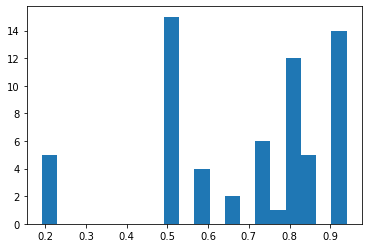

In [7]:
for marginal in marginals[0:1]:
    plt.hist(marginal, bins=20)
    plt.show()

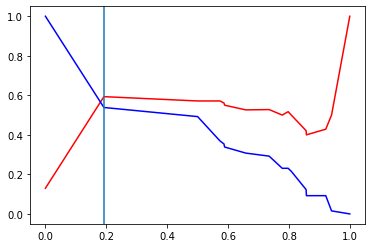

In [8]:
#   f1 = 2*precision*recall/(precision+recall) # Calculate F1 score
#   candidate_thresholds.append(thresholds[np.where(f1 == max(f1[(recall>0) & (recall < 1)]))]) # store threshold for highest F1 score with recall > 0 

plt.plot(thresholds_plot_presentation, precision_presentation, color="red") 
plt.plot(thresholds_plot_presentation, recall_presentation, color="blue")
plt.axvline(x=x_presentation)
plt.show()

## Challenging Error Classes

(Challenges for Toxic Comment Classification: An In-Depth Error Analysis' (https://arxiv.org/abs/1809.07572))

- Out of vocabulary: Germoney (ID: 1, 196)


- Self-addressed signal words: 
    - "weil wir dumm und träge sind" (Because we are stupid and lazy) (ID 212)
    - Tried to capture these with a labeling function and Spacy Tags -> Too little examples in dataset


- Hard classification in codebook :
    - DUMME Panzen ("Dumb Fucks") is active = Correct Intelligenz Candidate
    - keine gewalttätige Dummköpfe (no violent fools) slightly passive = Incorrect Intelligenz Candidate


- Sentence classified twice: One with, one without candidate gold label
    - Das zeigt einfach nur das die Regierung langsam kalte Füße bekommt. Da wurden mal auf die schnelle Steuergelder locker gemacht um diese Demo's von gehirntoten Deutschen auf die Beine zu stellen. Es hat damals schon in Sachsen begonnen und es wird wieder so sein. (ID 61 - No Intelligenz-Label)
    - Da wurden mal auf die schnelle Steuergelder locker gemacht um diese Demo's von gehirntoten Deutschen auf die Beine zu stellen. (ID 62 - Intelligenz-Label)


- Generative Model
    - Not completely comprehensive: We printed out the predicted label of the model and the result of our labeling functions for the candidates to get a feeling for which labeling functions have an impact and which not
   

## FastText Baseline Model

Baseline Model received by Arndt Allhorn with different training and testing datasets

In [9]:
testset = gold_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {base_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.286

Precision per class [hate, no hate]:	[0.99, 0.09]
Recall per class [hate, no hate]:	[0.232, 0.971]
F1 score per class [hate, no hate]:	[0.376, 0.165]



## Testing the baseline model with balanced data

In [10]:
testset = gold_balanced_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {base_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.629

Precision per class [hate, no hate]:	[0.909, 0.576]
Recall per class [hate, no hate]:	[0.286, 0.971]
F1 score per class [hate, no hate]:	[0.435, 0.723]



## Train fastText model with silver labeled snorkel dataset

In [11]:
#train_command = f"fasttext supervised -input {snorkelt_trainset} -output {trained_model[:-4]}"
#completed_process = subprocess.run(train_command, shell=True, check=True)

## Test fastText model with goldlabel dataset

In [12]:
testset = gold_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {trained_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.638

Precision per class [hate, no hate]:	[0.945, 0.102]
Recall per class [hate, no hate]:	[0.647, 0.514]
F1 score per class [hate, no hate]:	[0.768, 0.171]



In [13]:
testset = gold_balanced_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {trained_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.6

Precision per class [hate, no hate]:	[0.585, 0.621]
Recall per class [hate, no hate]:	[0.686, 0.514]
F1 score per class [hate, no hate]:	[0.632, 0.562]



### Comparison of Baseline model and Silver Snorkel-Label model
- Accuracy remains the same
- Recall and F1-Score are increased: Roughly +20% - 40% increase

| Model          | F1 imbalanced | F1 balanced |
|----------------|---------------|-------------|
| Baseline       |            0.376   |      0.435       |
| Snorkel Labels |    0.768           |      0.632       |

## Train with embeddings
- Use pretrained fastText embeddings based on German Wikipedia corpus

In [14]:
#train_command = f"fasttext supervised -pretrainedVectors ../model/cc.de.300.vec -dim 300 -input {snorkelt_trainset} -output {trained_with_embeddings_model[:-4]}"
#completed_process = subprocess.run(train_command, shell=True, check=True)

In [15]:
testset = gold_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {trained_with_embeddings_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.598

Precision per class [hate, no hate]:	[0.938, 0.088]
Recall per class [hate, no hate]:	[0.607, 0.486]
F1 score per class [hate, no hate]:	[0.737, 0.149]



In [16]:
testset = gold_balanced_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {trained_with_embeddings_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.514

Precision per class [hate, no hate]:	[0.514, 0.515]
Recall per class [hate, no hate]:	[0.543, 0.486]
F1 score per class [hate, no hate]:	[0.528, 0.5]



### Comparison of German embeddings + Snorkel-Labels and Silver Snorkel-Label model

| Model          | F1 imbalanced | F1 balanced |
|----------------|---------------|-------------|
| German embeddings + Snorkel       |            0.737   |      0.528       |
| Snorkel Labels |    0.768           |      0.632       |

## Try to improve the model by use Arndts Training set and add snorkel data...

In [17]:
add_snorkel_set_to_arndt_set()

train_command = f"fasttext supervised -input {joint_trainset} -output {joint_trained_model[:-4]}"
completed_process = subprocess.run(train_command, shell=True, check=True)

In [18]:
testset = gold_testset

test_command = f'python ../code/utils/fasttext_testing.py "$(cut -f 1 {testset})" "$(fasttext predict {joint_trained_model} {testset})"'
completed_process = subprocess.run(test_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

print(completed_process.stdout)

Accuracy: 0.573

Precision per class [hate, no hate]:	[0.958, 0.11]
Recall per class [hate, no hate]:	[0.565, 0.686]
F1 score per class [hate, no hate]:	[0.711, 0.189]



## Some Example Predictions

In [19]:
predict_command = f"fasttext predict {trained_model} {prediction_examples}"
completed_process = subprocess.run(predict_command, shell=True, check=True, encoding="utf-8", stdout=subprocess.PIPE)

with open(prediction_examples) as file:
    
    for prediction, text in zip(completed_process.stdout.split("\n")[:-1], file.readlines()):
        print(f"{prediction}\t-- {text[:-1]}")

__label__nohate	-- Eine junge Frau verlässt Deutschland, weil Deutschland mal wieder jedes kriminelle Assipack reinspazieren lässt.
__label__nohate	-- Der hat doch den A.... offen.
__label__nohate	-- Linker Abschaum!!
__label__hate	-- Ich mag alle menschen auch asylaten!
__label__nohate	-- Dieser Müll soll garnicht erst nach Deutschland hereingelassen werden
__label__nohate	-- Liebe <3
__label__nohate	-- Noch ein langweiliger Satz, der nichts zu sagen hat


# Outlook

## Labeling Functions
- Access to more gold labels to be able find more unique/special structures for the several candidates
- Add new labeling functions based on new insights
- Consider further Spacy tags

## General approaches
- Fuzzy Search
- Add examples for challenging error classes:
    - References to hate speech comments
    - Rhetorical questions



# Our conclusion
- Snorkel is best used if the structure of the target/hate speech candidate is well known
- The structure can then be targeted with appropriate labeling functions
- The trained generative model will create reasonable silver labels for input data